## Incorporating the Parasitoid Model into a Stochastic Model for Parameter Estimation

We have two main tasks here:
1. Assign priors to the parasitoid model parameters
2. Incorporate the parasitoid model into a larger stochastic model for field sampling and acquiring emergence data, so that we can compute the likelihood of our data given the model.

### Assigning priors to the parasitoid model parameters

The parasitoid model has the following parameters:
- current simulation day, $d$ (fixed)
- wind data, $\mathbf{w}(t,d)$ (fixed)
- $h$ flight probability function parameters, including:
    + $\lambda$, probability of flying during the day given ideal conditions
    + $f$ time probability function parameters, including:
        - morning logistic parameters, $a_1$, $b_1$
        - evening logistic parameters, $a_2$, $b_2$
    + $g$ wind flight probability function logistic parameters $a_w$, $b_w$
- diffusion covariance matrix parameters (perhaps two of these), can be split into:
    + $\sigma_x$ standard deviation in $x$ direction
    + $\sigma_y$ standard deviation in $y$ direction
    + $\rho$ correlation
- distance vs. windspeed scaling parameter $\mu_r$
- flight duration in minutes $t_{dur}$

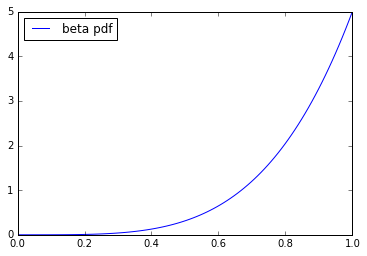

In [46]:
%matplotlib inline
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

a, b = 5,1

plt.figure()
x = np.linspace(0,1,100)
plt.plot(x,stats.beta.pdf(x,a,b),label='beta pdf')
plt.legend(loc='best')
plt.show()

$\lambda$ is a probability, so it can only take on continuous values between 0 and 1. We might assume it is close to 1 in starting our MCMC algorithm.

$$\lambda \sim \mbox{Beta}(\alpha = 5,\beta = 1)$$

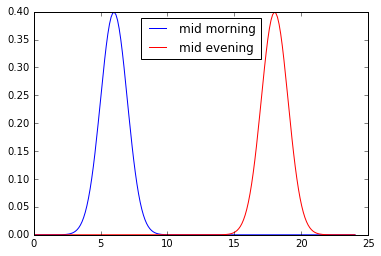

In [24]:
%matplotlib inline
from math import sqrt
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

mu1,sig1 = 6,1
mu2,sig2 = 18,1

rv1 = stats.norm(mu1,sig1)
rv2 = stats.norm(mu2,sig2)

plt.figure()
x = np.linspace(0,24,200)
plt.hold(True)
plt.plot(x,rv1.pdf(x),'b',label='mid morning')
plt.plot(x,rv2.pdf(x),'r',label='mid evening')
plt.legend(loc='best')
plt.hold(False)
plt.show()

$a_1$ and $a_2$ are parameters which control the position of their logistic functions. They center the logistic around a certain time, so the mark the point where the function value will be 0.5. They can take on continuous values, but must be limited: $a_1$ should take on a value sometime generally around sunrise, and $a_2$ should take on a value sometime generally around sunset. We can use a truncated normal distribution for each:

$$a_1 \sim \mathcal{N}(\mu=6,\sigma^2=1,a=0,b=12)\ \ \ \ \ \ \ \ \ a_2 \sim \mathcal{N}(\mu=18,\sigma^2=1,a=12,b=24)$$

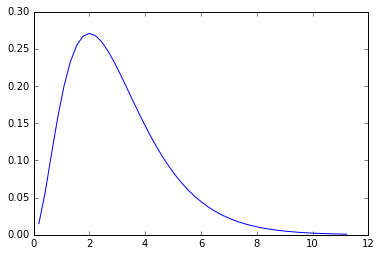

mean = 3.0, variance = 3.0


In [15]:
%matplotlib inline
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

k = 3
theta = 1
rv = stats.gamma(k,scale=theta)

plt.figure()
x = np.linspace(rv.ppf(0.001),rv.ppf(0.999))
plt.plot(x,rv.pdf(x))
plt.show()
gstats = rv.stats()
print('mean = {0}, variance = {1}'.format(gstats[0],gstats[1]))

$b_1$ and $b_2$ are parameters which control the scaling of their logistic functions. They can take on any positive value. Let's use the Gamma distribution. PyMC uses $\alpha$ and $\beta$. What starting values should we choose? Some exploration suggests that $k=2$ and $\theta = 0.5$ may be good values.

$$b_1,b_2 \sim \mbox{Gamma}(k=3,\theta=1)$$

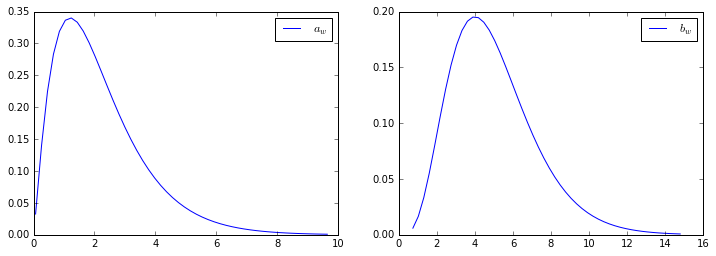

mean a_w = 2.2, variance a_w = 2.2
mean b_w = 5.0, variance b_w = 5.0


In [25]:
%matplotlib inline
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

k_a = 2.2
theta_a = 1
rv_a = stats.gamma(k_a,scale=theta_a)

k_b = 5
theta_b = 1
rv_b = stats.gamma(k_b,scale=theta_b)

plt.figure(figsize=(12,4))
plt.subplot(121)
x = np.linspace(rv_a.ppf(0.001),rv_a.ppf(0.999))
plt.plot(x,rv_a.pdf(x),label=r'$a_w$')
plt.legend()
plt.subplot(122)
x = np.linspace(rv_b.ppf(0.001),rv_b.ppf(0.999))
plt.plot(x,rv_b.pdf(x),label=r'$b_w$')
plt.legend()
plt.show()
gstats = rv_a.stats()
print('mean a_w = {0}, variance a_w = {1}'.format(gstats[0],gstats[1]))
gstats = rv_b.stats()
print('mean b_w = {0}, variance b_w = {1}'.format(gstats[0],gstats[1]))

The wind flight logistic parameters $a_w$ and $b_w$ need not have an upper bound. $a_w$ positions the distribution and should probably start at 2.2 given the result of Kristensen et al. genetic algorithm. $b_w$ is the shape parameter, and we don't have much info on this. We model both with a gamma distribution.

$$a_w \sim \mbox{Gamma}(k=2.2,\theta=1)\ \ \ \ \ \ \ \ \ b_w \sim \mbox{Gamma}(k=5,\theta=1)$$

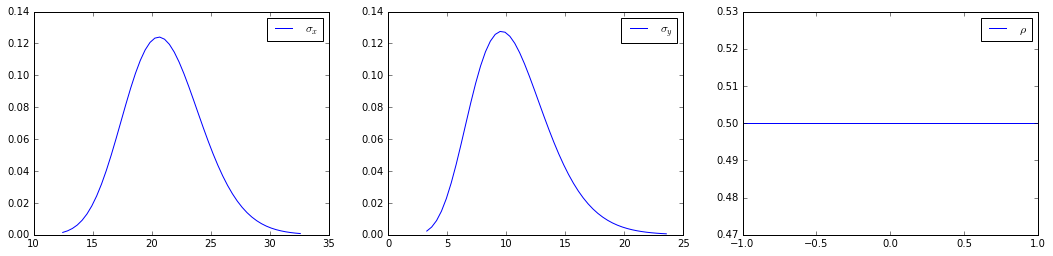

mean std x = 21.1, variance std x = 10.55
mean std y = 10.6, variance std y = 10.6


In [45]:
%matplotlib inline
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

k_x = 21.1*2
theta_x = 0.5
rv_x = stats.gamma(k_x,scale=theta_x)

k_y = 10.6
theta_y = 1
rv_y = stats.gamma(k_y,scale=theta_y)

rv_rho = stats.uniform(-1,2)

plt.figure(figsize=(18,4))
plt.subplot(131)
x = np.linspace(rv_x.ppf(0.001),rv_x.ppf(0.999))
plt.plot(x,rv_x.pdf(x),label=r'$\sigma_x$')
plt.legend()
plt.subplot(132)
x = np.linspace(rv_y.ppf(0.001),rv_y.ppf(0.999))
plt.plot(x,rv_y.pdf(x),label=r'$\sigma_y$')
plt.legend()
plt.subplot(133)
x = np.linspace(-1,1)
plt.plot(x,rv_rho.pdf(x),label=r'$\rho$')
plt.legend()
plt.show()
gstats = rv_x.stats()
print('mean std x = {0}, variance std x = {1}'.format(gstats[0],gstats[1]))
gstats = rv_y.stats()
print('mean std y = {0}, variance std y = {1}'.format(gstats[0],gstats[1]))


There may be two diffusion covariance matrices - one for in-flow diffusion and another for out-of-flow diffusion (a parasitoid is split between these two choices by the probability $\lambda$). Starting off, we might just assume they are the same and let the data dictate any difference.

For the diffusion covariance matrix parameters, $\sigma_x$ and $\sigma_y$ should be greater than zero and $\rho$ should be between -1 and 1. We may expect $\sigma_x$ and $\sigma_y$ to reflect a reasonable distance in meters that a parasitoid might fly during a single day under its own power, as given in the Kalbar study. $\rho$ could possibly be noninformative?? Ask Nadiah for value obtained from Kalbar study.

$$\sigma_x \sim \mbox{Gamma}(k=42.2,\theta=0.5),\ \ \ \ \ \sigma_y \sim \mbox{Gamma}(k=10.6,\theta=1)\ \ \ \ \ \rho \sim \mbox{Uniform}(-1,1)$$

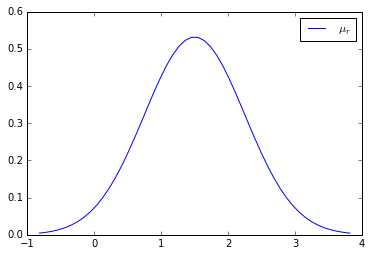

In [40]:
%matplotlib inline
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

mu = 1.5
sig = 0.75

mu_r = stats.norm(mu,sig)

plt.figure()
x = np.linspace(mu_r.ppf(0.001),mu_r.ppf(0.999))
plt.plot(x,mu_r.pdf(x),label=r'$\mu_r$')
plt.legend()
plt.show()

$\mu_r$, a parameter that scales wind speed to flight speed, is not really known but expected to be 1 or 2 given the previous study. Maybe a normal distribution with a standard deviation covering this range?

$$ \mu_r \sim \mathcal{N}(\mu=1.5,\sigma=0.75) $$

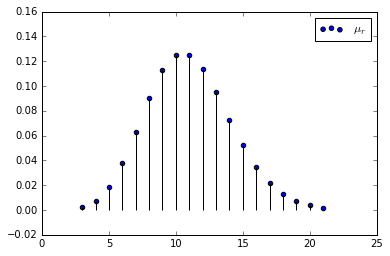

In [44]:
%matplotlib inline
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

lambdavar = 10

rv = stats.poisson(lambdavar,loc=1)

plt.figure()
x = np.arange(rv.ppf(0.001),rv.ppf(0.999))
plt.hold(True)
plt.scatter(x,rv.pmf(x),label=r'$\mu_r$')
plt.vlines(x,0,rv.pmf(x))
plt.legend()
plt.show()

Flight duration $t_{dur}$ is a finicky value... it represents an average time that parasitoids remain in flight given that they decide to take an in-flow flight sometime during the day. The real situation is complicated, probably dependent upon mating, landscape variables, age/sex of the wasp, etc. In the Python implemenation of the model, we have discretized time into minutes, so for purely numerical purposes, this number should be a postive integer value in minutes. Let's go with a Poission distribution shifted by 1 to avoid zero.

$$ t_{dur} \sim \mbox{Poi}(\lambda=10) $$

### Modeling parasitoid emergence sampling

I could not find any correlation between Whitefly emergence numbers in the sentinel fields and E. Hayati emergence numbers. As a result, I will ignore emergence data other than E. Hayati.

The parasitoid population model will return population densities in the form of expected population numbers per unit square. This expected value is then propagated forward in time by some function to get the expected number of wasps in a given location whose oviposition would result in an emergence date. We will model the actual number of emergences per date per unit square as a Poisson random variable with the model predicted population times an emergence-per-wasp factor as the mean. Each emergence in the area then has a chance of being observed with probability $\beta$, which will be location dependent. Let $X_i$ be the number of emergences in field $i$ when it is sampled and let $\gamma_i$ be the model expected population. Let $\xi$ be a population to expected emergence scaling factor. Let $Y_i$ be the number of wasps actually observed emerging.

$$ X_i\sim \mbox{Poi}(\xi\gamma_i) $$

Note: $\mbox{Gamma}(1,r)$ is $\mbox{Exp}(r)$ in $(\alpha,\beta)$ parametrization. Let $r$ be average time between ovipositions.
$$ \xi\sim \mbox{Gamma}(1,1) $$

$$ Y_i\sim \mbox{Bin}(X_i,\beta_i) $$

Then $Y_i$ is a thinned Poisson process:

$$ Y_i\sim \mbox{Poi}(\xi\gamma_i\beta_i) $$

The probability $\beta_i$ of observing a wasp in field $i$ is a random variable related to the density of wasps in the part of the field sampled. In a field with a perfectly uniform distribution of wasps,

$$ \beta_i = \frac{\tilde{A}}{A_i} $$

where $\tilde{A}$ is a random variable denoting the area sampled in each of the fields with total area $A_i$. Otherwise, $\beta_i$ has mean $\tilde{A}$, but its other moments change depending on the field-specific heterogenity. Then we might model

$$ \beta_i \sim \mbox{Beta}(\alpha,\beta\ \big\vert\ \mu=\frac{\alpha}{\alpha+\beta}=\frac{\tilde{A}}{A_i},\sigma^2=\mbox{min}(\mu,0.1)) $$

$$ \tilde{A} \sim \mbox{TruncNorm}(\mu,\sigma^2,0,\mbox{min}\ A_i) $$

Some examples of different Beta functions...


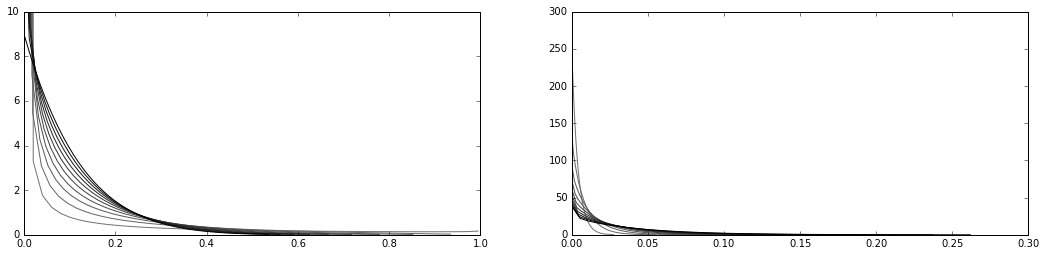

In [47]:
%matplotlib inline
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

mean = 0.1

def b_param(a):
    return a*(1-mean)/mean

rv_list = []
for ii in range(10):
    a = ii*0.1 + 0.1
    rv_list.append(stats.beta(a,b_param(a)))
    
rv_list2 = []
# fix var = mean. This only valid if mean < 0.5
for ii in range(10):
    mean = ii*0.004 +0.004
    a = 1-2*mean
    rv_list2.append(stats.beta(a,b_param(a)))
    
plt.figure(figsize=(18,4))
plt.hold(True)
plt.subplot(121)
for n,rv in enumerate(rv_list):
    x = np.linspace(rv.ppf(0.001),rv.ppf(0.999))
    plt.plot(x,rv.pdf(x),color='{}'.format(0.5-0.5*(n+1)/len(rv_list)))
plt.axis([0,1,0,10])
plt.subplot(122)
for n,rv in enumerate(rv_list2):
    x = np.linspace(rv.ppf(0.001),rv.ppf(0.999))
    plt.plot(x,rv.pdf(x),color='{}'.format(0.5-0.5*(n+1)/len(rv_list)))
#plt.axis([0,0.1,0,1000])
plt.show()

### Release field sampling

For the release field, we will use the same model only $\beta$ will be constant over each of the grid points, scaled only by the relative collection effort (number of leaves collected divided by the max number of leaves collected in a grid point). In this case, $\beta$ will be non-informative beyond assuming a value strictly between 0 and 1:

$$\beta\sim \mbox{Beta}(1,1)$$

$$ Y_n\sim \mbox{Poi}(\xi\gamma_n\beta\frac{c}{c_{max}}) $$